In [1]:
!rm -rf sample_data/ #extra space freeing

In [3]:
!unzip SCUT_FBP5500_downsampled.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/3_AM653.jpg        
  inflating: test/3_AM666.jpg        
  inflating: test/3_AM682.jpg        
  inflating: test/3_AM702.jpg        
  inflating: test/3_AM716.jpg        
  inflating: test/3_AM741.jpg        
  inflating: test/3_AM751.jpg        
  inflating: test/3_AM767.jpg        
  inflating: test/3_AM780.jpg        
  inflating: test/3_AM794.jpg        
  inflating: test/3_AM810.jpg        
  inflating: test/3_AM827.jpg        
  inflating: test/3_AM837.jpg        
  inflating: test/3_AM848.jpg        
  inflating: test/3_AM865.jpg        
  inflating: test/3_AM884.jpg        
  inflating: test/3_AM899.jpg        
  inflating: test/3_AM909.jpg        
  inflating: test/3_AM919.jpg        
  inflating: test/3_AM933.jpg        
  inflating: test/3_AM954.jpg        
  inflating: test/3_AM978.jpg        
  inflating: test/3_AM989.jpg        
  inflating: test/3_AM998.jpg        
  inflating: test/3_CF115.jpg        

In [2]:
import os
import random
import numpy as np
import tensorflow as tf

def set_global_seed(seed=42):
    # 1. Python built-in RNG
    random.seed(seed)

    # 2. NumPy RNG
    np.random.seed(seed)

    # 3. TensorFlow RNG
    tf.random.set_seed(seed)

    # 4. (Optional) CUDA / cuDNN determinism
    os.environ["TF_DETERMINISTIC_OPS"] = "1"   # makes conv/pool deterministic
    os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

    print(f"✅ Global seed set to {seed}")

# Call this once, at the top of your notebook / main.py
set_global_seed(1234)

✅ Global seed set to 1234


In [4]:
import tensorflow as tf

# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
import tensorflow as tf
import os

def parse_label_from_path(path):
    fname = tf.strings.regex_replace(path, r".*[\\/]", "")          # -> b"7_CM668.jpg"
    # 2) grab the leading integer before the underscore
    num   = tf.strings.regex_replace(fname, r"^([0-9]+)_.*$", r"\1")# -> b"7"
    # 3) to float and shape (1,) for regression
    label = tf.strings.to_number(num, out_type=tf.float32)
    return tf.reshape(label, [1])  # regression target shape [1]

def process_img(path):
    img = tf.io.decode_jpeg(tf.io.read_file(path), channels=3)
    img = tf.image.resize(img, (80, 80)) / 255.0
    y = parse_label_from_path(path)
    return img, y  # <-- (features, label)

train_dataset = (tf.data.Dataset.list_files("training/*.jpg")).map(process_img,num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
validation_dataset = (tf.data.Dataset.list_files("validation/*.jpg")).map(process_img,num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [6]:
import tensorflow as tf

In [7]:
test_dataset = (
    tf.data.Dataset.list_files("test/*.jpg")
    .map(process_img, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(8)
    .prefetch(tf.data.AUTOTUNE)
)

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def show_predictions(model, test_dataset, num_examples=5):
    # Collect all images, labels, and predictions
    all_images, all_labels, all_preds = [], [], []

    for batch_imgs, batch_labels in test_dataset:
        preds = model.predict(batch_imgs, verbose=0)
        all_images.append(batch_imgs.numpy())
        all_labels.append(batch_labels.numpy())
        all_preds.append(preds)

    # Concatenate everything
    all_images = np.concatenate(all_images)
    all_labels = np.concatenate(all_labels).flatten()
    all_preds = np.concatenate(all_preds).flatten()

    # Compute absolute errors
    errors = np.abs(all_preds - all_labels)
    sorted_idx = np.argsort(errors)

    # Choose subsets
    best_idx = sorted_idx[:num_examples]
    worst_idx = sorted_idx[-num_examples:]
    random_idx = np.random.choice(len(all_images), num_examples, replace=False)

    # Helper function to plot examples
    def plot_examples(indices, title):
        plt.figure(figsize=(15, 3))
        for i, idx in enumerate(indices):
            plt.subplot(1, num_examples, i + 1)
            plt.imshow(all_images[idx])
            plt.axis("off")
            plt.title(f"True: {all_labels[idx]:.2f}\nPred: {all_preds[idx]:.2f}\nErr: {errors[idx]:.2f}")
        plt.suptitle(title, fontsize=14)
        plt.show()

    # Show best, worst, and random predictions
    plot_examples(best_idx, f"Best Predictions (Lowest Absolute Errors)")
    plot_examples(worst_idx, f"Worst Predictions (Highest Absolute Errors)")
    plot_examples(random_idx, f"Random Predictions")


def model_evaluate(model, test_dataset):
  results = model.evaluate(test_dataset, return_dict=True)
  print("Test MSE:", results["mse"])
  print("Test MAE:", results["mean_absolute_error"])
  show_predictions(model, test_dataset, num_examples=8)

In [9]:
import matplotlib.pyplot as plt

def plot_history(history):
  plt.figure()
  plt.plot(history.history["loss"], label="train")
  plt.plot(history.history.get("val_loss", []), label="val")
  plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
  plt.show()

In [10]:
import tensorflow as tf
from tensorflow.keras import layers as L, Model, callbacks

class SingleBar(callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.pbar = tqdm(
            total=self.params['epochs'],
            desc='training',
            leave=False,              # keeps it to a single rolling line
            dynamic_ncols=True,
            bar_format='{l_bar}{bar} {n_fmt}/{total_fmt} [{elapsed}<{remaining}] {postfix}'
        )

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        tail = {k: f"{logs[k]:.4f}" for k in ("loss","mse","rounded_mae") if k in logs}
        # 1) set postfix WITHOUT forcing an immediate refresh
        self.pbar.set_postfix(tail, refresh=False)
        # 2) now advance the bar (this triggers a single refresh)
        self.pbar.update(1)

    def on_train_end(self, logs=None):
        self.pbar.close()

class AttractRegressorModel(Model):
    def __init__(self, architecture:dict):
        super().__init__()
        self.architecture = architecture
        self.layer_list = self._build_model(architecture)
        self.is_sequential = self.architecture.get("computation_sequence", "sequential") == "sequential"
        if self.is_sequential:
          self.layer_list = tf.keras.Sequential(self.layer_list)
        #for residuality
        self.residual_map = {}
        self.required_outputs = set()
        if not self.is_sequential:
            self._parse_computation_sequence()

    def _parse_computation_sequence(self, architecture):
        computation_sequence = self.architecture.get("computation_sequence")
        for conn_str in computation_sequence:
            try:
                start, end = map(int, conn_str.split('-'))
                if start >= end:
                    raise ValueError(f"Start index ({start}) must be less than end index ({end}) in connection '{conn_str}'.")

                # Map the end point to the start point for quick lookups
                self.residual_map[end] = start

                # We need to store the output of the layer *before* the start index
                self.required_outputs.add(start - 1)
                print(f"  - Will add output of layer {start - 1} to output of layer {end}")

            except ValueError as e:
                raise ValueError(f"Invalid connection format: '{conn_str}'. Expected 'start-end'. Details: {e}")

    def _build_cnn_layer(self,params):
      return L.Conv2D(
            filters=params["out_channels"],
            kernel_size=params.get("kernel_size", 3),
            padding=params.get("padding", "same"),
            kernel_initializer=params.get("initialization", "he_normal"),
            use_bias=params.get("use_bias", True)
        ) if "dilation" not in params else L.Conv2D(
            filters=params["out_channels"],
            kernel_size=params.get("kernel_size", 3),
            padding=params.get("padding", "same"),
            dilation_rate=params.get("dilation", 1),
            kernel_regularizer=tf.keras.regularizers.l2(params.get("l2_rate", 0)),
            use_bias=params.get("use_bias", True)
        )

    def _build_maxpool_layer(self,params):
      return L.MaxPooling2D(
            pool_size=params.get("pool_size", 2),
            strides=params.get("strides", 2)
        )

    def _build_batchnorm_layer(self,layer):
      return L.BatchNormalization()

    def _build_activation_layer(self, params: dict):
        name = params.get("name", "relu").lower()
        if name == 'leakyrelu':
            return L.LeakyReLU(alpha=params.get("alpha", 0.1))
        return L.Activation(name)

    def _build_dropout_layer(self, params):
      return L.Dropout(rate=params.get("rate", 0.5))

    def _build_last_layer(self, params: dict):
      """
      Builds the final block of the network (the head).
      This can be a multi-layer sequence, so it returns a Sequential model.
      """
      head_type = params.get("head_type", "mlp") # Default to mlp
      drop = float(params.get("dropout_rate", 0.0) or 0.0)
      if head_type == "mlp":
        print("  - Building MLP Head (Flatten -> Dense [+ optional Dropout])")
        layers = [
            L.Flatten(),
            L.Dense(2048),
        ]
        if drop > 0:
            layers.append(L.Dropout(drop))
        layers += [
            L.Dense(2048),
        ]
        if drop > 0:
            layers.append(L.Dropout(drop))
        layers += [
            L.Dense(1)
        ]
        return tf.keras.Sequential(layers)

      elif head_type == "fully_convolutional":

        print("  - Building FCN Head (GlobalAvgPool -> Dense)")
        layers = [
            L.GlobalAveragePooling2D(),
            L.Dense(512, activation="relu"),
        ]
        if drop > 0:
          layers.append(L.Dropout(drop))
        layers.append(L.Dense(1))
        return tf.keras.Sequential(layers)
      else:
        raise ValueError(f"Unknown last_layer head_type: {head_type}")

    def _build_model(self,architecture):
      modules = []
      build_maps = {
          "cnn": self._build_cnn_layer,
          "maxpool": self._build_maxpool_layer,
          "batchnorm": self._build_batchnorm_layer,
          "activation": self._build_activation_layer,
          "last_layer": self._build_last_layer,
          "dropout": self._build_dropout_layer
      }
      for module in architecture["layers"]:
          if module["type"] == "noop":
            continue
          build_function = build_maps[module["type"]]
          layer = build_function(module)
          modules.append(layer)
      return modules

    def call(self, inputs, training=False):
        # Sequential Operations
        if self.is_sequential:
            return self.layer_list(inputs, training=training)

        # If there are skip connections:
        outputs_cache = {}
        x = inputs
        # Check if the initial input tensor needs to be stored for a connection
        if 0 in self.required_outputs:
            outputs_cache[0] = x

        # --- Main Forward Pass with Inline Additions ---
        for i, layer in enumerate(self.layer_list): ## even though Activations are not a layer we treated as it is.
            layer_num = i + 1

            # Forward passing
            x = layer(x, training=training)

            # If this layer is an endpoint for a residual connection, perform the addition
            if layer_num in self.residual_map:
                start_idx = self.residual_map[layer_num]

                if (start_idx - 1) not in outputs_cache:
                    raise RuntimeError(f"Logic error: Required output from layer {start_idx - 1} was not cached.")

                shortcut_path = outputs_cache[start_idx - 1]

                # --- Shape Validation ---
                if x.shape[1:] != shortcut_path.shape[1:]:
                    raise ValueError(
                        f"Shape mismatch for residual connection {start_idx}-{layer_num}. "
                        f"Cannot add shortcut shape {shortcut_path.shape} to main shape {x.shape}. "
                        "You may need a projection layer (1x1 Conv) to match dimensions."
                    )

                # Perform the addition, which now becomes the main path tensor 'x'
                x = L.Add()([x, shortcut_path])

            # Check if the activation output is the residual for feature
            if layer_num in self.required_outputs:
                outputs_cache[layer_num] = x

        return x

In [11]:

# ====== plotting: train + val ======
import matplotlib.pyplot as plt

def plot_train_val_history(hist, title="Training"):
    e = range(1, len(hist["loss"])+1)

    plt.figure(figsize=(13,6))

    # Loss (MSE loss)
    plt.subplot(1,2,1)
    plt.plot(e, hist["loss"], label="train loss")
    if "val_loss" in hist: plt.plot(e, hist["val_loss"], label="val loss")
    plt.xlabel("epoch"); plt.ylabel("MSE loss"); plt.title("Loss"); plt.grid(True, alpha=0.3); plt.legend()

    # MAE (rounded)
    plt.subplot(1,2,2)
    # If you also log unrounded MAE, you can plot it too; here we focus on rounded MAE per the assignment
    if "rounded_mae" in hist:       plt.plot(e, hist["rounded_mae"], label="train rMAE")
    if "val_rounded_mae" in hist:   plt.plot(e, hist["val_rounded_mae"], label="val rMAE")
    # (optionally show unrounded)
    if "mean_absolute_error" in hist:        plt.plot(e, hist["mean_absolute_error"], '--', alpha=0.5, label="train MAE")
    if "val_mean_absolute_error" in hist:    plt.plot(e, hist["val_mean_absolute_error"], '--', alpha=0.5, label="val MAE")

    plt.xlabel("epoch"); plt.ylabel("MAE"); plt.title("MAE"); plt.grid(True, alpha=0.3); plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def prepare_train(ds, batch_size=32, seed=1337):
    return (ds
            .shuffle(8192, seed=seed, reshuffle_each_iteration=True)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))

# Useful utility tool for adding l2 regularization to layers
def add_l2_to_layers(layers, l2_rate=1e-4):
    for layer in layers:
        if layer["type"] in ["cnn", "last_layer"]:
            layer["l2_rate"] = l2_rate
    return layers

def prepare_val(ds, batch_size=32):
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
from IPython.display import clear_output

class LivePlot(callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.h = {"loss":[], "val_loss":[], "mean_absolute_error":[], "val_mean_absolute_error":[]}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for k in self.h.keys():
            if k in logs: self.h[k].append(logs[k])
        clear_output(wait=True)
        e = range(1, len(self.h["loss"])+1)
        plt.figure(figsize=(13,6))
        # Loss
        plt.subplot(1,2,1)
        plt.plot(e, self.h["loss"], label="train loss")
        if self.h["val_loss"]: plt.plot(e, self.h["val_loss"], label="val loss")
        plt.title("Loss"); plt.grid(True, alpha=0.3); plt.legend()
        # MAE
        plt.subplot(1,2,2)
        if self.h["mean_absolute_error"]: plt.plot(e, self.h["mean_absolute_error"], '--', label="train MAE")
        if self.h["val_mean_absolute_error"]: plt.plot(e, self.h["val_mean_absolute_error"], '--', label="val MAE")
        plt.title("MAE"); plt.grid(True, alpha=0.3); plt.legend()
        plt.tight_layout(); plt.show()
def train_with_val(model,
                   train_ds_full,
                   val_ds_full,
                   epochs=100,
                   batch_size=32,
                   lr=1e-3,
                   name="model",
                   early_stop=True):
    train_ds = prepare_train(train_ds_full, batch_size=batch_size)
    val_ds   = prepare_val(val_ds_full, batch_size=batch_size)

    # Build once (subclassed model)
    x0, _ = next(iter(train_ds))
    _ = model(x0, training=True)

    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=opt, loss="mse",
        metrics=[
            tf.keras.metrics.MeanSquaredError(name="mse"),
            tf.keras.metrics.MeanAbsoluteError(name="mean_absolute_error"),
        ]
    )

    for layer in model.layers:
      if hasattr(layer, 'kernel_regularizer') and layer.kernel_regularizer:
        print(f"{layer.name}: L2 = {layer.kernel_regularizer.l2}")


    cbs = [LivePlot(),SingleBar(), callbacks.TerminateOnNaN()]
    if early_stop:
        cbs += [
            callbacks.ReduceLROnPlateau(monitor="val_mean_absolute_error", factor=0.5, patience=10, min_lr=1e-6, verbose=1, mode='min'),
            callbacks.EarlyStopping(monitor="val_mean_absolute_error", patience=20, restore_best_weights=True, verbose=1, mode='min'),
        ]

    print(f"\n[train] {name} | lr={lr} | bs={batch_size} | epochs={epochs}")
    h = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=0,                 # SingleBar drives the progress
        callbacks=cbs
    ).history
    print(h["val_loss"])
    # summary
    last_idx = len(h["loss"]) - 1
    best_idx = (np.nanargmin(h["val_mean_absolute_error"])
                if "val_mean_absolute_error" in h and len(h["val_mean_absolute_error"]) > 0
                else last_idx)
    last = {
        "epoch": last_idx + 1,
        "loss": h["loss"][last_idx],
        "val_loss": h.get("val_loss", [np.nan])[last_idx],
        "mae": h.get("mean_absolute_error", [np.nan])[last_idx],
        "val_mae": h.get("val_mean_absolute_error", [np.nan])[last_idx],
    }
    best = {
        "epoch": best_idx + 1,
        "loss": h["loss"][best_idx],
        "val_loss": h.get("val_loss", [np.nan])[best_idx],
        "mae": h.get("mean_absolute_error", [np.nan])[best_idx],
        "val_mae": h.get("val_mean_absolute_error", [np.nan])[best_idx],
    }

    print(f"[{name}] LAST @ epoch {last['epoch']}: "
          f"loss={last['loss']:.4f} | val_loss={last['val_loss']:.4f} | "
          f"MAE={last['mae']:.4f} | val_MAE={last['val_mae']:.4f}")

    print(f"[{name}] BEST (val_MAE) @ epoch {best['epoch']}: "
          f"loss={best['loss']:.4f} | val_loss={best['val_loss']:.4f} | "
          f"MAE={best['mae']:.4f} | val_MAE={best['val_mae']:.4f}")

    # plot
    plot_train_val_history(h, title=f"{name} train/val")
    model_evaluate(model,test_dataset)
    return h

In [14]:
general_learning_rate = 3e-4
general_batch_size = 8
general_epochs= 70

In [12]:
from tensorflow.keras import callbacks
from tqdm import tqdm
def add_l2_to_layers(layers, l2_rate=1e-4):
    for layer in layers:
        if layer["type"] in ["cnn", "last_layer"]:
            layer["l2_rate"] = l2_rate
    return layers
def create_vgg_16_configs(use_batch_norm=False,l2_norm = 0, dropout_rate=0, dropout_only_dense = False, cnn_initialization_type="he_normal", fc_init_type="he_normal"):
  use_dropout = dropout_rate > 0
  all_layers_dropout = use_dropout and not dropout_only_dense
  # VGG16 Layers
  if not all_layers_dropout:
    vgg16_layers = [
        # Block 1
        {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        # [40,40,64] RF 6
        # Block 2
        {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        # [20,20,128] RF 16
        # Block 3
        {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        # [10,10,256] RF 44
        # Block 4
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        # [5,5,512] RF 100
        # Block 5
        # In original VGG 16 They have 5 block with RF 220. We have 80x80 image that is more than enough. So we concluded directly with mlp
        {"type": "last_layer", "head_type": "mlp", "dropout_rate": dropout_rate}
        #
    ]
  else:
    vgg16_layers = [
        # Block 1
        {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        {"type": "dropout", "rate": 0.1},
        # [40,40,64] RF 6
        # Block 2
        {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        {"type": "dropout", "rate": 0.1},
        # [20,20,128] RF 16
        # Block 3
        {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        {"type": "dropout", "rate": 0.1},
        # [10,10,256] RF 44
        # Block 4
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        {"type": "dropout", "rate": 0.1},
        # [5,5,512] RF 100
        # Block 5
        # In original VGG 16 They have 5 block with RF 220. We have 80x80 image that is more than enough. So we concluded directly with mlp
        {"type": "last_layer", "head_type": "mlp", "dropout_rate": dropout_rate}
        #
    ]
  if l2_norm > 0:
    add_l2_to_layers(vgg16_layers,l2_norm)
  vgg16_config = {
      "layers": vgg16_layers,
      "computation_sequence": "sequential"
  }
  return vgg16_config
def create_vgg16_dilated_configs(use_batch_norm=False,l2_norm = 0, dropout_rate=0, dropout_only_dense = False, initialization_type="he_normal", remove_bias=False):
  use_dropout = dropout_rate > 0
  all_layers_dropout = use_dropout and not dropout_only_dense
  vgg16_dilated_layers = []
  if not all_layers_dropout:
    vgg16_dilated_layers = [
        # Block 1 (same)
        {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},


        # Block 2 (same)
        {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},


        # Block 4 (dilated; no pool)
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 2, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 2, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 2, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},

        # Block 5 (stronger dilation; no pool)
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 4, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 4, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 4, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "last_layer", "head_type": "fully_convolutional", "dropout_rate": dropout_rate}
    ]
    print(f"Entered here. {vgg16_dilated_layers}")
  else:
    vgg16_dilated_layers = [
        # Block 1 (same)
        {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        {"type": "dropout", "rate": 0.1},
        # Block 2 (same)
        {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "maxpool", "pool_size": 2, "strides": 2},
        {"type": "dropout", "rate": 0.1},

        # Block 4 (dilated; no pool)
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 2, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 2, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 2, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "dropout", "rate": 0.1},

        # Block 5 (stronger dilation; no pool)
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 4, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 4, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 4, "initialization": initialization_type},
        {"type":"batchnorm"} if use_batch_norm else {"type":"noop"},{"type": "activation", "name": "relu"},
        {"type": "dropout", "rate": 0.1},

        {"type": "last_layer", "head_type": "fully_convolutional","dropout_rate": dropout_rate}
    ]
  print(vgg16_dilated_layers)
  if l2_norm > 0:
    add_l2_to_layers(vgg16_dilated_layers,l2_norm)
  vgg16_config = {
      "layers": vgg16_dilated_layers,
      "computation_sequence": "sequential"
  }
  vgg_dilated_layers_config = {
      "layers": vgg16_dilated_layers,
      "computation_sequence": "sequential"
  }
  return vgg_dilated_layers_config

def build_model(vgg_model_config):
  vgg_model = AttractRegressorModel(vgg_model_config)
  return vgg_model


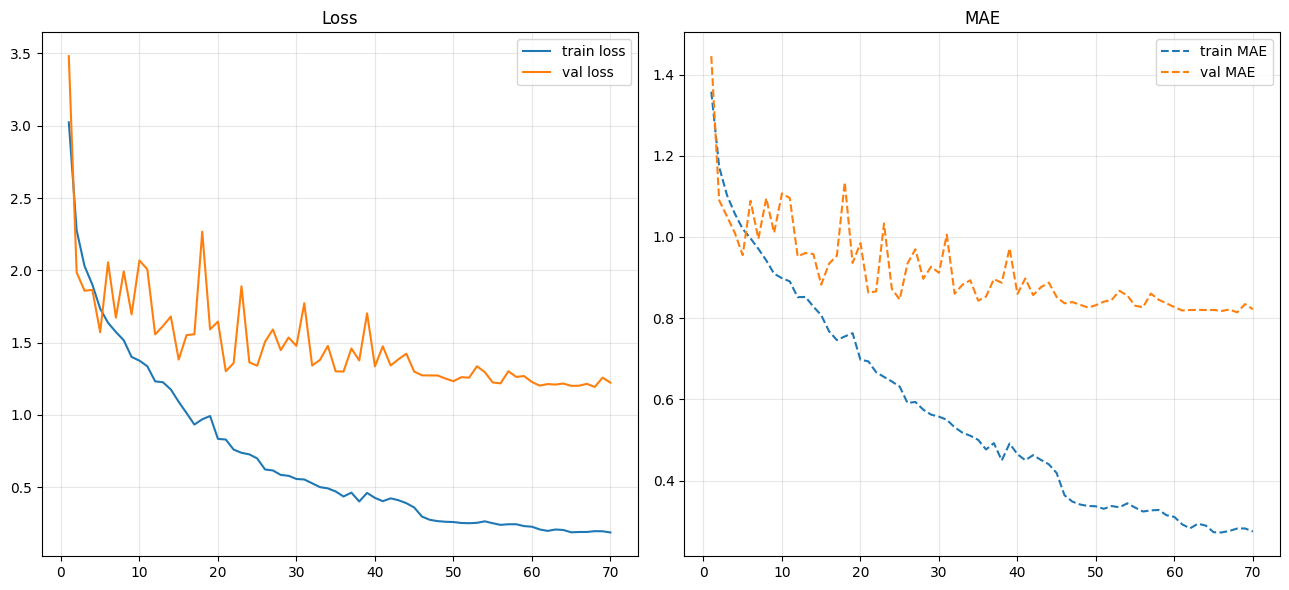

Restoring model weights from the end of the best epoch: 68.


[3.481311559677124, 1.986342191696167, 1.8590770959854126, 1.8648393154144287, 1.5721371173858643, 2.0559122562408447, 1.6730821132659912, 1.9934276342391968, 1.695833444595337, 2.068587303161621, 2.007622718811035, 1.5574195384979248, 1.6153147220611572, 1.6810929775238037, 1.3829095363616943, 1.5523605346679688, 1.5582408905029297, 2.2674732208251953, 1.5920820236206055, 1.646000862121582, 1.3025952577590942, 1.3588522672653198, 1.8902814388275146, 1.363986611366272, 1.3407429456710815, 1.506321907043457, 1.5916130542755127, 1.4486238956451416, 1.5359638929367065, 1.4779164791107178, 1.7727924585342407, 1.3423361778259277, 1.3807692527770996, 1.4779897928237915, 1.3015767335891724, 1.3004202842712402, 1.460010051727295, 1.3770103454589844, 1.702735424041748, 1.3363049030303955, 1.475015640258789, 1.3423876762390137, 1.3853952884674072, 1.423844575881958, 1.3004004955291748, 1.2742334604263306, 1.273413896560669, 1.2730082273483276, 1.25148606300354, 1.2338120937347412, 1.261223912239

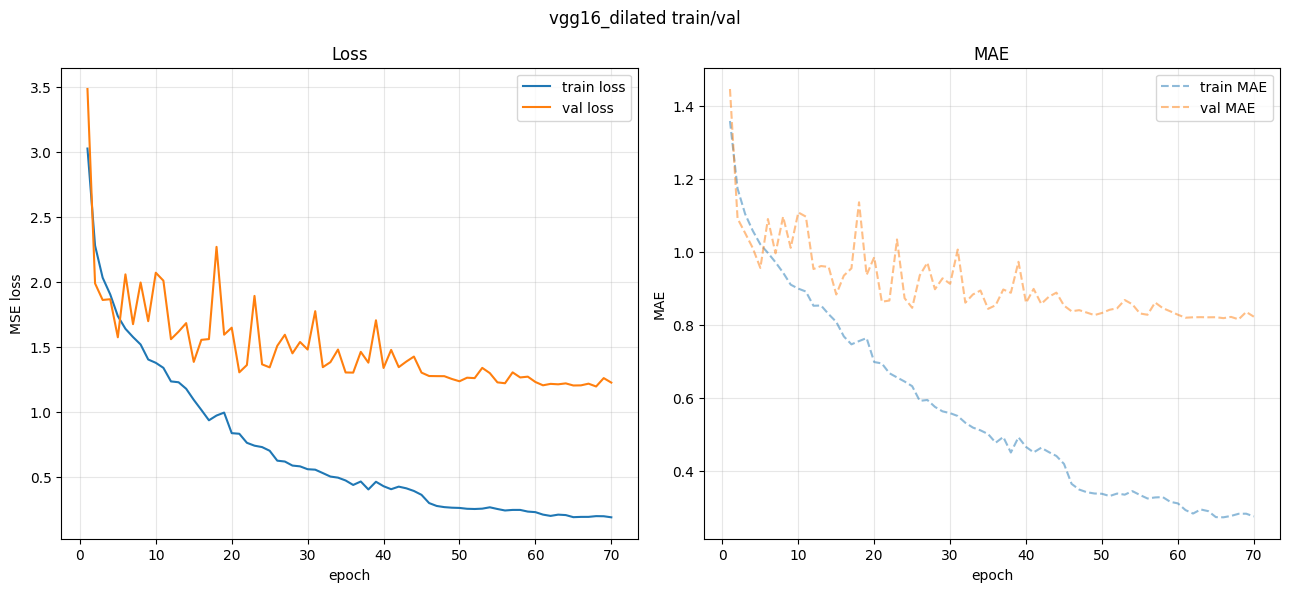

112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.1617 - mean_absolute_error: 0.7782 - mse: 1.1008
Test MSE: 1.0653916597366333
Test MAE: 0.7724418640136719


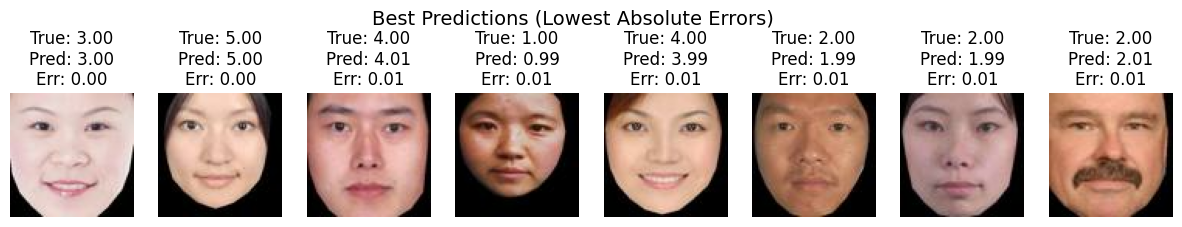

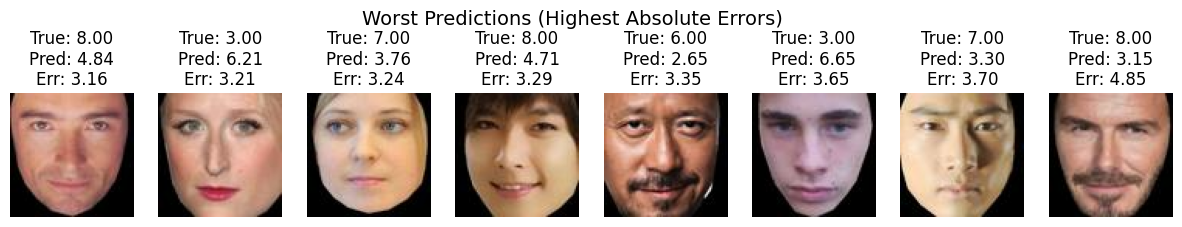

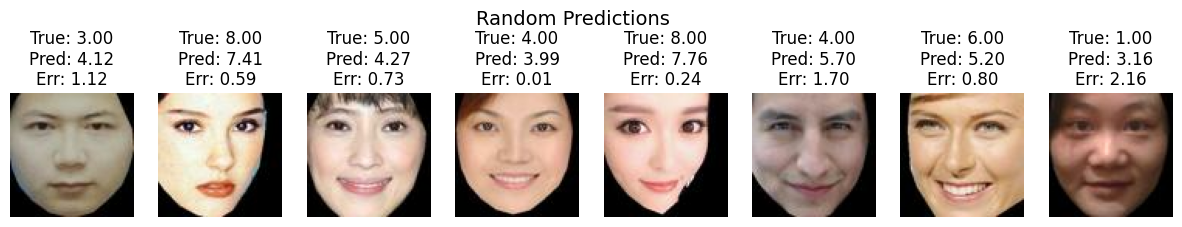

In [ ]:
dilated_vgg= build_model(create_vgg16_dilated_configs(use_batch_norm=True, l2_norm=1e-5, initialization_type="glorot_normal",dropout_only_dense=False,dropout_rate=0.3))
_ = train_with_val(
    dilated_vgg, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16_dilated",early_stop=True
)
del dilated_vgg